## Sentiment Analysis Using LstmClassifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
# loading Imdb movie review dataset
train = pd.read_csv('dataset/labeledTrainData.tsv',quoting=3,delimiter='\t')

In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


#### Removing html content, stopwords, lower-casing from reviews

In [4]:
from bs4 import BeautifulSoup
import re
stop_words = set(['the','and','a','has','she','of','to','is','had','these','it','in','i','this','that','s','was','as','for','with','t','you','on','he','are','his','have','be','at','they','by','an','there','her','my','we','me','do'])
def clean_review(movie_review):
    #Removing HTML tags
    review = BeautifulSoup(movie_review, "lxml").get_text()
    
    #Removing non alphabetic words
    review = re.sub("[^a-zA-Z]"," ",review)
    review = review.lower()
    tokens = nltk.word_tokenize(review)
    cleaned_review = ""
    for token in tokens:
        if token not in stop_words:
            cleaned_review += " %s "%(token)
    return cleaned_review

In [5]:
train.review = train.review.apply(clean_review)

In [6]:
def word_count(review):
    return len(review.split())

[0, 1000, 0, 12000]

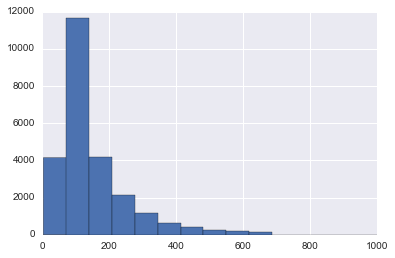

In [7]:
wc = train.review.apply(word_count)
plt.hist(wc,25)
plt.axis([0, 1000, 0, 12000])

### After cleaning most of the reviews have around 100 words so using 100 as max_seq_length

In [8]:
import itertools
tokenized_sentences = [nltk.word_tokenize(sent) for sent in train.review]
 
# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print "Found %d unique words tokens." % len(word_freq.items())

Found 74175 unique words tokens.


In [9]:
# list of top 100 most common words in the vocabulary with their counts
word_freq.most_common(100)

[(u'movie', 44030),
 (u'but', 42613),
 (u'film', 40146),
 (u'not', 31725),
 (u'one', 26788),
 (u'all', 23976),
 (u'who', 21435),
 (u'so', 20611),
 (u'from', 20494),
 (u'like', 20274),
 (u'or', 18004),
 (u'just', 17766),
 (u'about', 17372),
 (u'out', 17108),
 (u'if', 16799),
 (u'what', 16166),
 (u'can', 15767),
 (u'some', 15744),
 (u'good', 15140),
 (u'more', 14246),
 (u'when', 14178),
 (u'very', 14065),
 (u'up', 13291),
 (u'time', 12723),
 (u'no', 12722),
 (u'even', 12646),
 (u'would', 12436),
 (u'which', 12050),
 (u'story', 11983),
 (u'only', 11915),
 (u'really', 11736),
 (u'see', 11474),
 (u'their', 11381),
 (u'were', 10784),
 (u'well', 10661),
 (u'than', 9916),
 (u'much', 9765),
 (u'get', 9310),
 (u'bad', 9301),
 (u'been', 9286),
 (u'people', 9285),
 (u'will', 9209),
 (u'other', 9160),
 (u'also', 9155),
 (u'into', 9109),
 (u'first', 9061),
 (u'great', 9058),
 (u'because', 9045),
 (u'how', 8897),
 (u'him', 8878),
 (u'don', 8843),
 (u'most', 8784),
 (u'made', 8362),
 (u'its', 8177),
 

In [10]:
# frequency of 10_000th most common word because we limit the vicabulary to top 10_000 words only
word_freq.most_common(10000)[-1]

(u'opus', 30)

In [11]:
vocab_size = 10000
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"
pad_token = "PADDING"

# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocab_size- (4+1))
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
index_to_word.append(pad_token)
index_to_word.append(sentence_start_token)
index_to_word.append(sentence_end_token)

word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

In [12]:
max_seq_length = 100
def get_idx_vector(review):
    review = '%s %s %s'%(sentence_start_token, review, sentence_end_token)
    review_tokens = nltk.word_tokenize(review)
    unknown_token_id = word_to_index[unknown_token]
    padding_token = word_to_index[pad_token]
    idx_vector = np.zeros([1,max_seq_length]) + padding_token
    limit = min(len(review_tokens),max_seq_length)
    for i in xrange(limit):
        idx_vector[0][i] = word_to_index.get(review_tokens[i],unknown_token_id)
    return idx_vector    

In [13]:
get_idx_vector(train.review[0])

array([[  9.99700000e+03,   5.00000000e+00,   4.89000000e+02,
          1.29000000e+02,   1.40000000e+02,   5.06000000e+02,
          9.03300000e+03,   9.80000000e+01,   5.94000000e+02,
          2.56900000e+03,   1.83000000e+02,   1.09000000e+02,
          9.68000000e+02,   6.03000000e+02,   8.80000000e+01,
          2.53000000e+02,   9.99500000e+03,   2.53000000e+02,
          9.99500000e+03,   1.33000000e+02,   2.38000000e+02,
          1.10000000e+01,   1.42000000e+02,   3.70000000e+01,
          7.54000000e+02,   2.55800000e+03,   4.40000000e+01,
          1.85000000e+02,   6.00000000e+00,   1.55000000e+02,
          3.00000000e+01,   5.87000000e+02,   4.18200000e+03,
          1.10000000e+01,   2.38000000e+02,   5.60000000e+01,
          2.20000000e+01,   2.87000000e+02,   6.70000000e+02,
          2.44000000e+03,   1.00000000e+01,   1.29100000e+03,
          9.99500000e+03,   1.32000000e+02,   4.94100000e+03,
          1.32000000e+02,   7.27000000e+02,   2.00000000e+00,
        

In [14]:
trX = [get_idx_vector(review) for review in train.review]

In [15]:
trX = np.array(trX)

In [16]:
trX = trX.reshape([-1,max_seq_length])
trX.shape

(25000, 100)

In [17]:
trY = train.sentiment.values
trY = pd.get_dummies(trY).values
trY.shape

(25000, 2)

In [18]:
from sklearn.cross_validation import train_test_split
Xtrain, Xval, ytrain, yval = train_test_split(trX, trY, test_size=0.25)

In [19]:
from SequenceClassifier import LstmClassifier
clf = LstmClassifier(vocab_size=vocab_size,num_classes=2,max_seq_length=max_seq_length,hidden_size=32,
                     embedding_size=32, ckpt_dir="./sa_ckpt_dir", summary_dir="/tmp/sa_lstmClf_logs")

In [32]:
clf.train(Xtrain,ytrain,n_iters=1500,learning_rate=3e-4,keep_prob=0.45)

./sa_ckpt_dir/model.ckpt-3500
Loss at step 3500: 0.22449
Loss at step 3510: 0.249602
Loss at step 3520: 0.125896
Loss at step 3530: 0.121497
Loss at step 3540: 0.117479
Loss at step 3550: 0.157544
Loss at step 3560: 0.118991
Loss at step 3570: 0.104193
Loss at step 3580: 0.112824
Loss at step 3590: 0.0897209
Loss at step 3600: 0.129032
Loss at step 3610: 0.113146
Loss at step 3620: 0.179208
Loss at step 3630: 0.144841
Loss at step 3640: 0.222349
Loss at step 3650: 0.121481
Loss at step 3660: 0.161337
Loss at step 3670: 0.123959
Loss at step 3680: 0.272062
Loss at step 3690: 0.216111
Loss at step 3700: 0.162712
Loss at step 3710: 0.0411431
Loss at step 3720: 0.126267
Loss at step 3730: 0.128701
Loss at step 3740: 0.0970572
Loss at step 3750: 0.212418
Loss at step 3760: 0.186206
Loss at step 3770: 0.119732
Loss at step 3780: 0.334139
Loss at step 3790: 0.0930535
Loss at step 3800: 0.296091
Loss at step 3810: 0.215721
Loss at step 3820: 0.401601
Loss at step 3830: 0.255239
Loss at step 38

In [33]:
# validation set accuracy & loss
clf.score(Xval,yval)

array([ 0.85568   ,  0.38781864])

In [34]:
# train set accuracy & loss
clf.score(Xtrain,ytrain)

array([ 0.95664   ,  0.12257269])